In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import join

from clip_grounding.utils.paths import REPO_PATH
sys.path.append(join(REPO_PATH, "CLIP_explainability/Transformer-MM-Explainability/"))

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import CLIP.clip as clip
import cv2
from PIL import Image
from glob import glob
from natsort import natsorted

from clip_grounding.utils.paths import REPO_PATH
from clip_grounding.utils.io import load_json
from clip_grounding.utils.visualize import set_latex_fonts, show_grid_of_images, get_colors
from clip_grounding.utils.image import pad_to_square
from clip_grounding.datasets.png_utils import show_images_and_caption
from clip_grounding.datasets.png import (
    PNG,
    visualize_item,
    overlay_segmask_on_image,
    overlay_relevance_map_on_image,
    get_text_colors,
)
from clip_grounding.evaluation.clip_on_png import (
    process_entry_image_to_text,
    process_entry_text_to_image,
    interpret_and_generate,
)

## Load dataset

In [4]:
dataset = PNG(dataset_root=join(REPO_PATH, "data/panoptic_narrative_grounding"), split="val2017")

## Load model

In [5]:
# load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

### Text-to-Image

In [6]:
def visualize_entry_text_to_image(entry, pad_images=True, figsize=(18, 5)):
    test_img, test_texts, orig_image = process_entry_text_to_image(entry, unimodal=False)
    outputs = interpret_and_generate(model, test_img, test_texts, orig_image, return_outputs=True, show=False)
    relevance_map = outputs[0]["image_relevance"]
    
    image_with_mask = overlay_segmask_on_image(entry["image"], entry["image_mask"])
    if pad_images:
        image_with_mask = pad_to_square(image_with_mask)
    
    image_with_relevance_map = overlay_relevance_map_on_image(entry["image"], relevance_map)
    if pad_images:
        image_with_relevance_map = pad_to_square(image_with_relevance_map)
    
    text_colors = get_text_colors(entry["text"], entry["text_mask"])
    
    show_images_and_caption(
        [image_with_mask, image_with_relevance_map],
        entry["text"], text_colors, figsize=figsize,
        image_xlabels=["Ground truth segmentation", "Predicted relevance map"]
    )

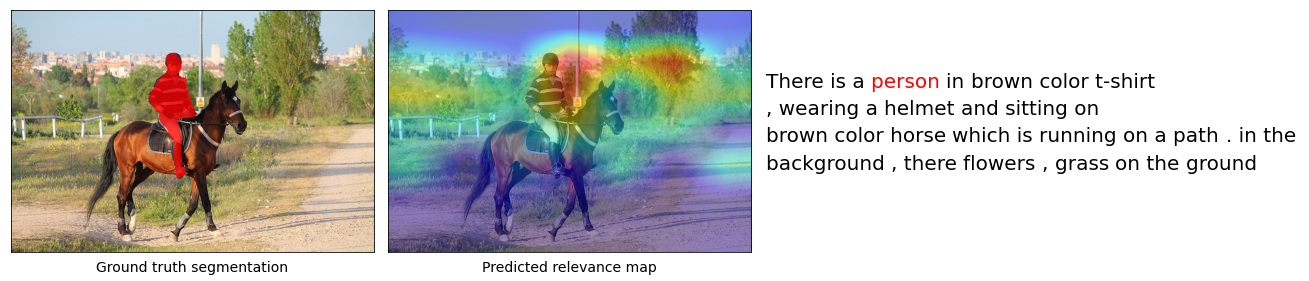

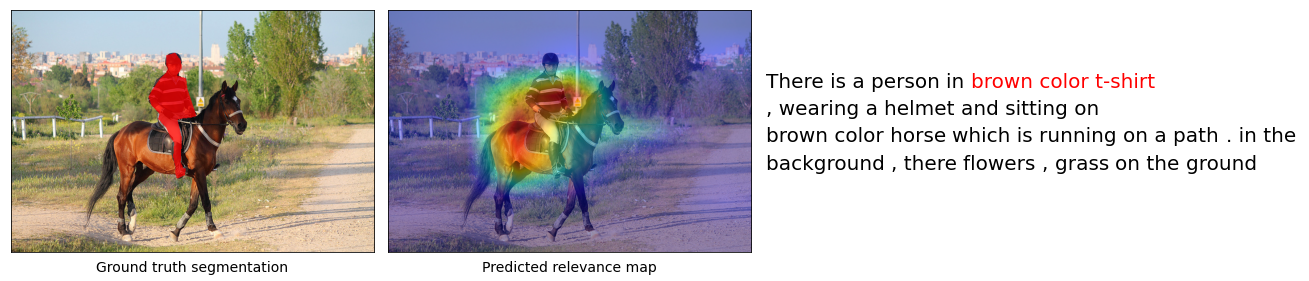

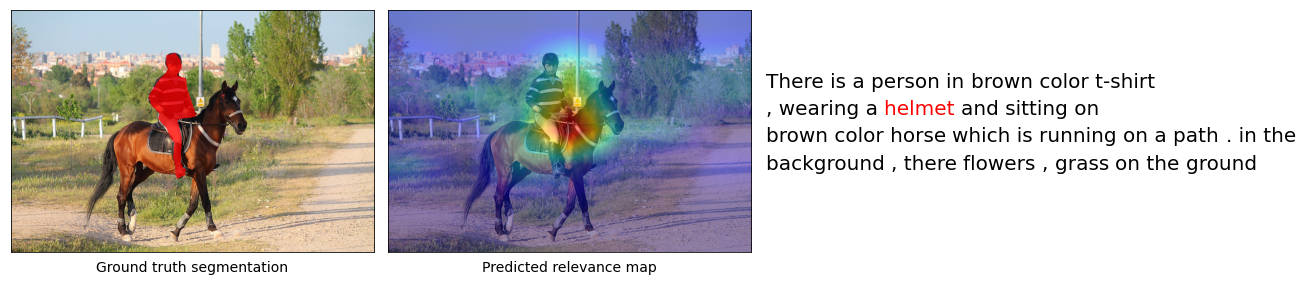

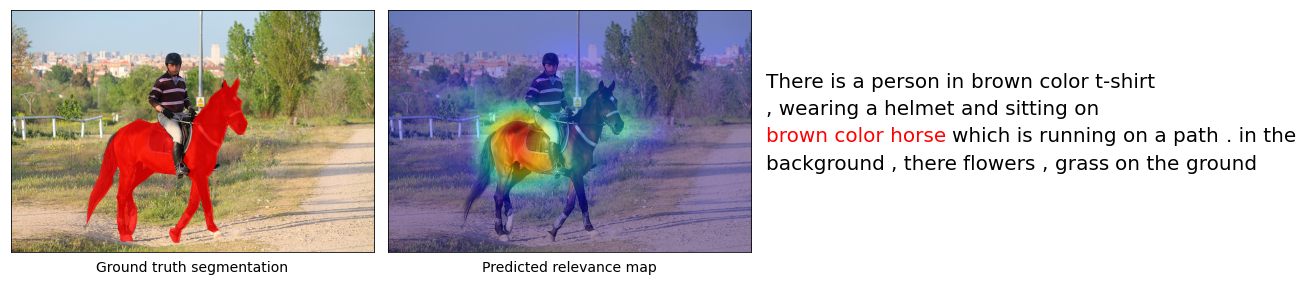

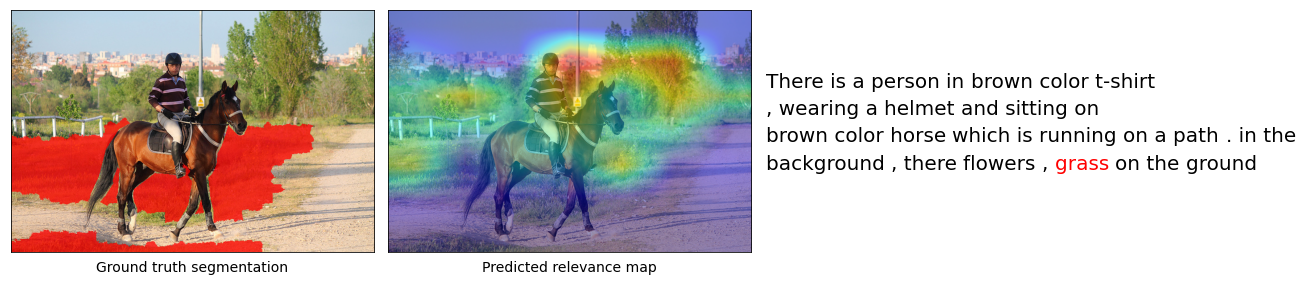

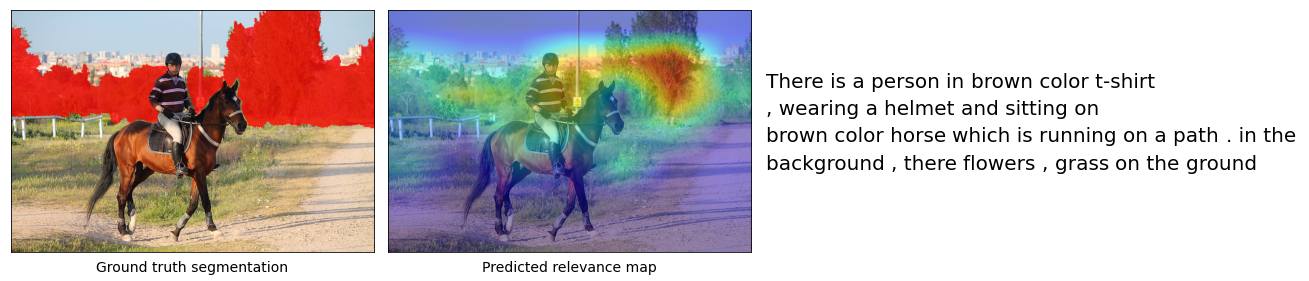

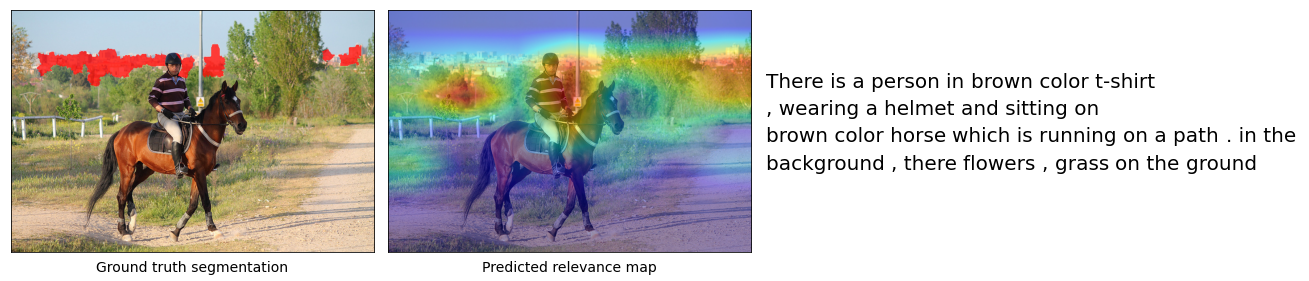

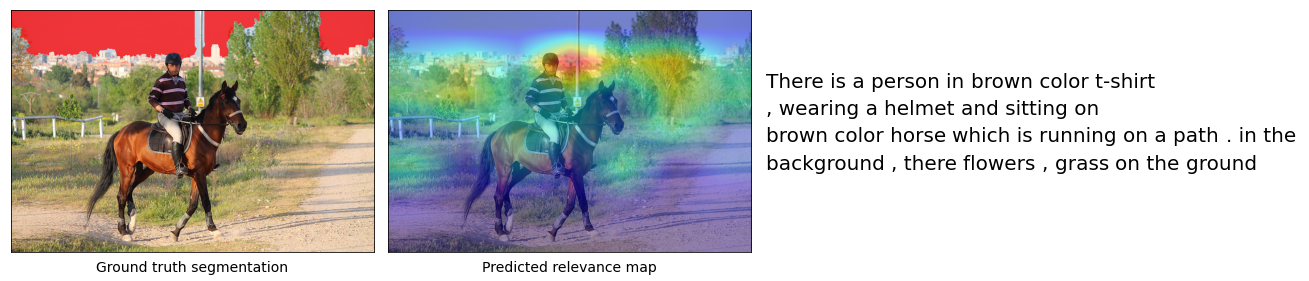

In [25]:
idx = 42
instance = dataset[idx]
extension = "png"

instance_dir = join(REPO_PATH, "figures", f"instance-{idx}")
os.makedirs(instance_dir, exist_ok=True)

for i, entry in enumerate(instance):
    del entry["full_caption"]

    visualize_entry_text_to_image(entry, pad_images=False, figsize=(19, 4))
    
    save_path = instance_dir
    plt.savefig(join(instance_dir, f"viz-{i}.{extension}"), bbox_inches="tight")

In [26]:
def create_and_save_gif(filenames, save_path, **kwargs):
    import imageio
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(save_path, images, **kwargs)

In [27]:
filenames = natsorted(glob(join(instance_dir, "viz-*.png")))
# save_path = join(instance_dir, "together.gif")
save_path = join(REPO_PATH, "media", "sample-3.gif")

create_and_save_gif(filenames, save_path, duration=2)

## Image-to-text

In [148]:
def highlight_text(x,y,ls,lc,fig, ax,**kw):

    t = ax.transAxes

    for s,c in zip(ls,lc):
        
        text = ax.text(x,y,s, transform=t, **kw)
        text.set_bbox(dict(facecolor=c, alpha=0.5, edgecolor=c))
        text.draw(fig.canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(text._transform, x=ex.width, units='dots')

In [155]:
def visualize_entry_image_to_text(entry, tokens_per_line=10, height_per_line=0.11, fontsize=20, figsize=(14, 4), **kwargs):
    
    scores = outputs[0]["text_scores"]
    softmax_scores = torch.nn.functional.softmax(scores)
    tokens = outputs[0]["tokens_decoded"]
    
    palette = "Greens"
    cmap = plt.get_cmap(palette)
    colors = [cmap(s) for s in scores.numpy()]

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(1, 2, figure=fig)

    ax = fig.add_subplot(gs[0, :1])
    ax.axis("off")
    # ax.set_title("Word importance", fontsize=25)

    tokens[0] = tokens[0].capitalize()
    split_tokens = np.array_split(np.array(tokens), len(tokens) // tokens_per_line)
    split_colors = np.array_split(np.array(colors), len(tokens) // tokens_per_line)

    y = 0.7
    for _tokens, _colors in zip(split_tokens, split_colors):
        highlight_text(0., y, _tokens, _colors, fig, ax, fontsize=fontsize, **kwargs)
        y -= height_per_line

    ax = fig.add_subplot(gs[0, 1])
    ax.imshow(orig_image)
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.tight_layout()

    # plt.show()

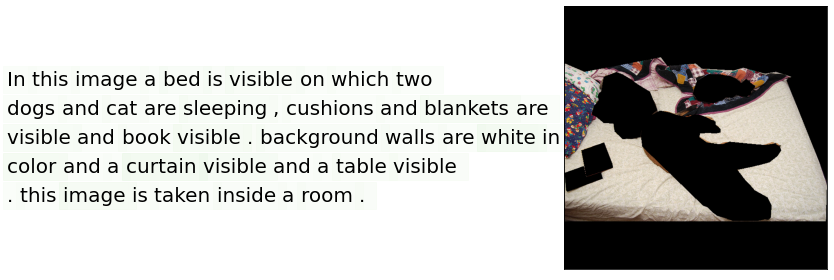

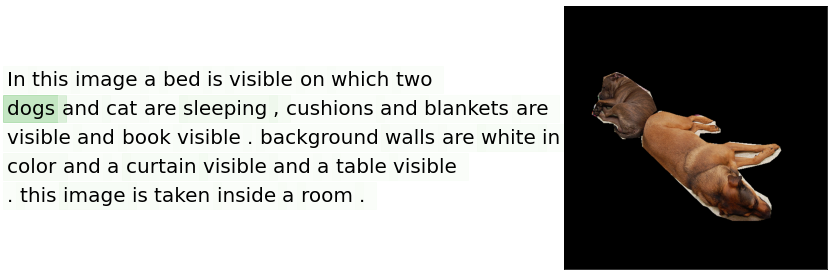

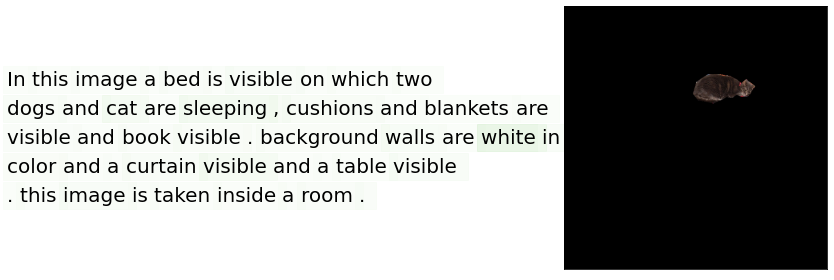

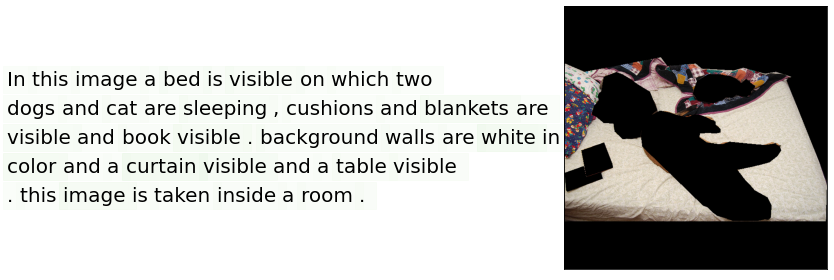

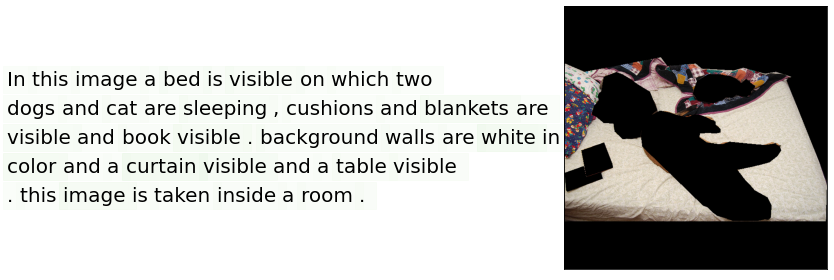

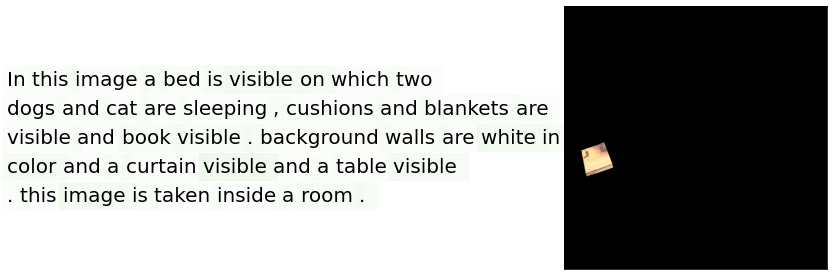

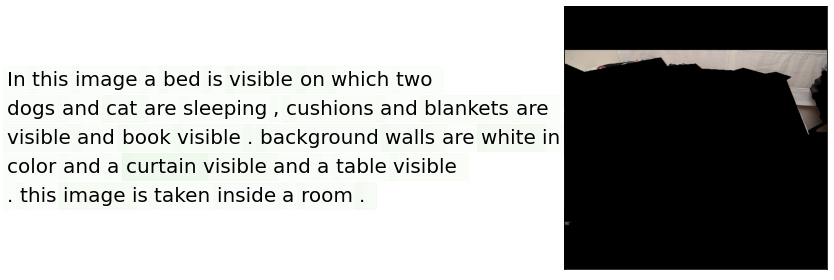

In [156]:
idx = 100
instance = dataset[idx]
extension = "png"

instance_dir = join(REPO_PATH, "figures", f"instance-{idx}")
os.makedirs(instance_dir, exist_ok=True)

for i, entry in enumerate(instance):
    del entry["full_caption"]

    img, texts, orig_image = process_entry_image_to_text(entry, unimodal=False)
    outputs = interpret_and_generate(model, img, texts, orig_image, return_outputs=True, show=False)
    
    visualize_entry_image_to_text(entry, tokens_per_line=9, horizontalalignment='left', figsize=(12, 4))
    plt.savefig(join(instance_dir, f"viz-i2t-{i}.{extension}"), bbox_inches="tight")

    # visualize_entry_text_to_image(entry, pad_images=False, figsize=(19, 4))
    
    # save_path = instance_dir
    # plt.savefig(join(instance_dir, f"viz-{i}.{extension}"), bbox_inches="tight")

In [22]:
entry.keys()

dict_keys(['image', 'text', 'image_mask', 'text_mask'])

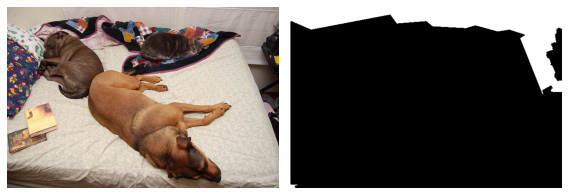

In [23]:
show_grid_of_images([entry["image"], entry["image_mask"]])

In [39]:
scores = outputs[0]["text_scores"]
softmax_scores = torch.nn.functional.softmax(scores)

tokens = outputs[0]["tokens_decoded"]

In [40]:
softmax_scores

tensor([0.0175, 0.0175, 0.0183, 0.0188, 0.0195, 0.0181, 0.0246, 0.0228, 0.0190,
        0.0181, 0.0205, 0.0175, 0.0237, 0.0175, 0.0185, 0.0176, 0.0208, 0.0183,
        0.0211, 0.0181, 0.0214, 0.0191, 0.0218, 0.0246, 0.0242, 0.0223, 0.0248,
        0.0175, 0.0338, 0.0189, 0.0181, 0.0175, 0.0175, 0.0475, 0.0281, 0.0177,
        0.0176, 0.0177, 0.0208, 0.0180, 0.0177, 0.0272, 0.0176, 0.0178, 0.0198,
        0.0178, 0.0196, 0.0258])

In [93]:
palette = "Greens"
cmap = plt.get_cmap(palette)
colors = [cmap(s / 3) for s in scores.numpy()]

In [94]:
from matplotlib import transforms

In [102]:
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec


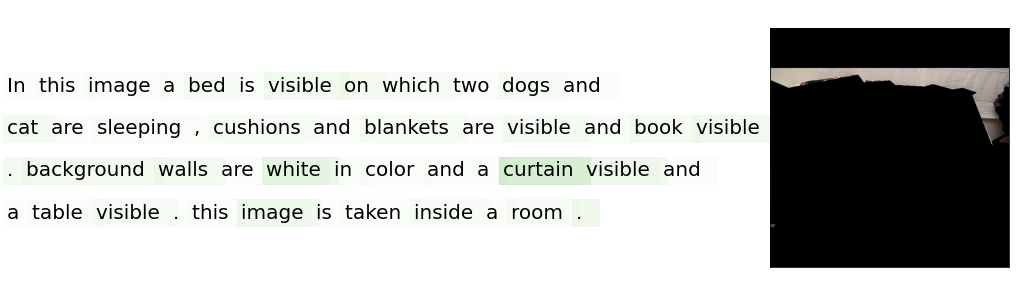

In [115]:
fig = plt.figure(figsize=(14, 4), constrained_layout=True)
gs = GridSpec(1, 3, figure=fig)


ax = fig.add_subplot(gs[0, :2])
ax.axis("off")
# ax.set_title("Word importance", fontsize=25)

height_per_line = 0.15
tokens_per_line = 10

tokens[0] = tokens[0].capitalize()
split_tokens = np.array_split(np.array(tokens), len(tokens) // tokens_per_line)
split_colors = np.array_split(np.array(colors), len(tokens) // tokens_per_line)

y = 0.7
for _tokens, _colors in zip(split_tokens, split_colors):
    highlight_text(0., y, _tokens, _colors, fig, ax, fontsize=20)
    y -= height_per_line

ax = fig.add_subplot(gs[0, 2])
ax.imshow(orig_image)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

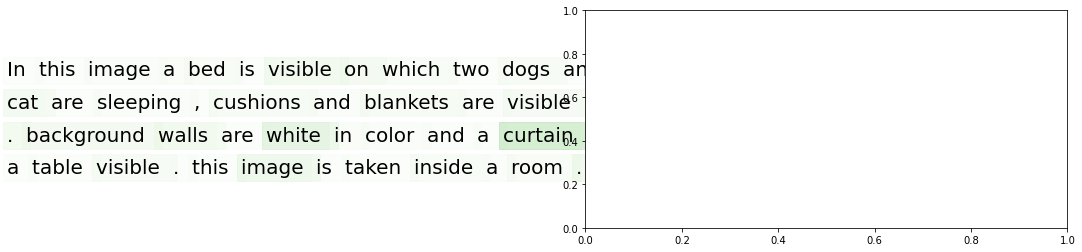

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(19, 4))

ax = axes[0]
ax.axis("off")

height_per_line = 0.15
tokens_per_line = 10

tokens[0] = tokens[0].capitalize()
split_tokens = np.array_split(np.array(tokens), len(tokens) // tokens_per_line)
split_colors = np.array_split(np.array(colors), len(tokens) // tokens_per_line)

y = 0.7
for _tokens, _colors in zip(split_tokens, split_colors):
    highlight_text(0., y, _tokens, _colors, fig, ax, fontsize=20)
    y -= height_per_line

# highlight_text(0., 0.7, tokens[:10], colors[:10], fig, ax, fontsize=20)
# highlight_text(0., 0.7 - 0.15, tokens[10:20], colors[10:20], fig, ax, fontsize=20)

## Debugging code for a single entry

In [71]:
idx = 100
instance = dataset[idx]
entry = instance[1]
del entry["full_caption"]

In [58]:
entry.keys()

dict_keys(['image', 'text', 'image_mask', 'text_mask'])

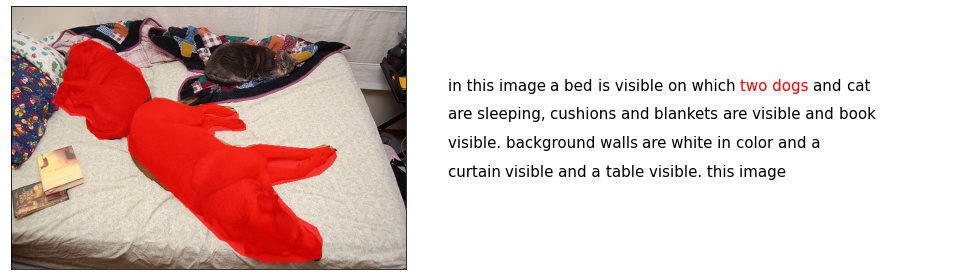

In [59]:
visualize_item(**entry)

### Visualize everything together

In [61]:
test_img, test_texts, orig_image = process_entry_text_to_image(entry, unimodal=False)
outputs = interpret_and_generate(model, test_img, test_texts, orig_image, return_outputs=True, show=False)
relevance_map = outputs[0]["image_relevance"]

In [62]:
image_with_mask = overlay_segmask_on_image(entry["image"], entry["image_mask"])
image_with_mask = pad_to_square(image_with_mask)

In [63]:
image_with_mask.size

(640, 640)

In [64]:
relevance_map.min(), relevance_map.max(), relevance_map.shape

(0.0, 1.0, (224, 224))

In [65]:
image_with_relevance_map = overlay_relevance_map_on_image(entry["image"], relevance_map)
image_with_relevance_map = pad_to_square(image_with_relevance_map)

In [66]:
text_colors = get_text_colors(entry["text"], entry["text_mask"])

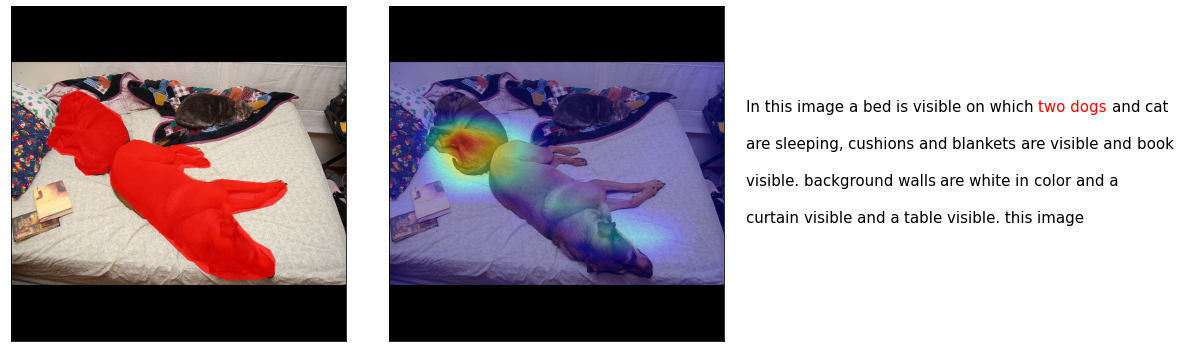

In [69]:
show_images_and_caption([image_with_mask, image_with_relevance_map], entry["text"], text_colors, figsize=(18, 5))
plt.savefig("../figures/viz-1.pdf", bbox_inches="tight")